# Long Short Term Memory (LSTM)
- Long Short Term Memory units are recurrent neural network(RNN).
- A common LSTM unit is composed of a cell, an input gate an output gate and  a forget gate.
- The cell is responsible for "Remembering" values over arbitrary time intervals.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
def plot_predictions(test,predicted):
  plt.plot(test, color='red', label='Real IBM Stock Price')
  plt.plot(predicted, color='blue', label='Predicted IBM Stock Price')
  plt.title('IBM Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('IBM Stock Price')
  plt.legend()
  plt.show()

def return_rmse(test,predicted):
  rmse = math.sqrt(mean_squared_error(test,predicted))
  print("The root mean squared error is {}".format(rmse))

In [8]:
dataset = pd.read_csv('/content/DataSet/IBM_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=['Date'])


In [9]:
dataset

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM


In [10]:
# Read High
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

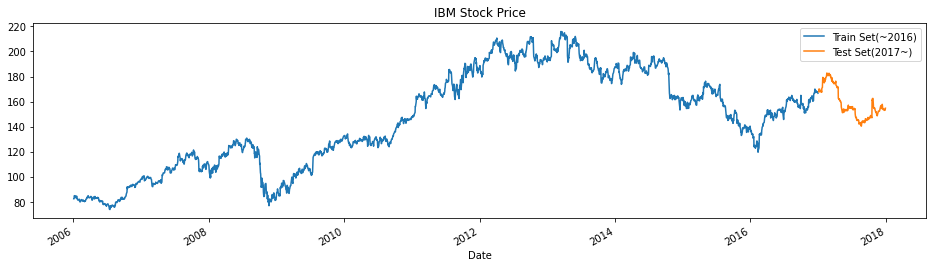

In [12]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Train Set(~2016)','Test Set(2017~)'])
plt.title('IBM Stock Price')
plt.show()

In [15]:
TIME_STEPS = 60
def create_sequences(values, time_steps = TIME_STEPS):
    output=[]
    for i in range(len(values) - time_steps -1):
    #for i in range(len(values) - time_steps):
        output.append(values[i: (i+time_steps)])
    #return output
    return np.expand_dims(output, axis=2)

def create_label(values, time_steps = TIME_STEPS):
  output=[]
  for i in range(len(values) - time_steps - 1):
    output.append(values[i+time_steps])
  return output


In [23]:
# Scaling the train set And Divide DataSet int Train and Test
#sc = MinMaxScaler(feature_range=(0,1))
# 원래 feature_range로 따로 설정을 해야했었나? 기억이 안남.
# -> Default로 모든 Feature의 값이 0~1 사이에 있도록 데이터를 재조정한다.
sc = MinMaxScaler()
training_set_scaled = sc.fit(training_set)

In [27]:
training_set_scaled = sc.transform(training_set)
test_set_scaled=sc.transform(test_set)

In [28]:
training_set.shape

(2769, 1)

In [68]:
X_train = []
y_train = []

X_train = create_sequences(training_set_scaled)
y_train = create_label(training_set_scaled)
X_test = create_sequences(test_set_scaled)
y_test = create_label(test_set_scaled)

In [69]:
print(X_train.shape)
print(len(y_train))

(2708, 60, 1, 1)
2708


In [70]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [71]:
print(X_train.shape)

(2708, 60, 1)


In [75]:
#y_train = np.reshape(y_train, len(y_train),1,1)
y_train = np.reshape(y_train,(len(y_train),1,1))

In [33]:
X_train2 = np.reshape(X_train, (X_train.shape[1],X_train.shape[0],1))

In [34]:
X_train2.shape

(60, 2708, 1)

In [44]:
X_train2[0][0].shape

(1,)

In [45]:
X_train.shape[1]

60

In [76]:
regressor=Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=5))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop', loss='mse')


In [77]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 5)                

In [78]:
regressor.fit(X_train, y_train, epochs=200,batch_size=128)

Epoch 1/200
22/22 [==============================] - 12s 185ms/step - loss: 0.0490
Epoch 2/200
22/22 [==============================] - 3s 152ms/step - loss: 0.0278
Epoch 3/200
22/22 [==============================] - 3s 152ms/step - loss: 0.0230
Epoch 4/200
22/22 [==============================] - 4s 182ms/step - loss: 0.0235
Epoch 5/200
22/22 [==============================] - 3s 154ms/step - loss: 0.0204
Epoch 6/200
22/22 [==============================] - 3s 153ms/step - loss: 0.0194
Epoch 7/200
22/22 [==============================] - 4s 169ms/step - loss: 0.0191
Epoch 8/200
22/22 [==============================] - 4s 165ms/step - loss: 0.0179
Epoch 9/200
22/22 [==============================] - 3s 154ms/step - loss: 0.0156
Epoch 10/200
22/22 [==============================] - 4s 173ms/step - loss: 0.0168
Epoch 11/200
22/22 [==============================] - 4s 182ms/step - loss: 0.0150
Epoch 12/200
22/22 [==============================] - 3s 158ms/step - loss: 0.0157
Epoch 13/200

In [79]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(y_test,(len(y_test),1,1))

In [80]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 2s 30ms/step


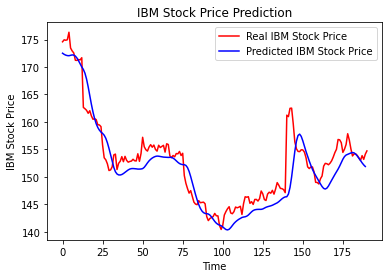

In [82]:
plot_predictions(test_set[60:],predicted_stock_price)